# L7: Build a Crew to Tailor Job Applications

In this lesson, you will built your first multi-agent system.

# 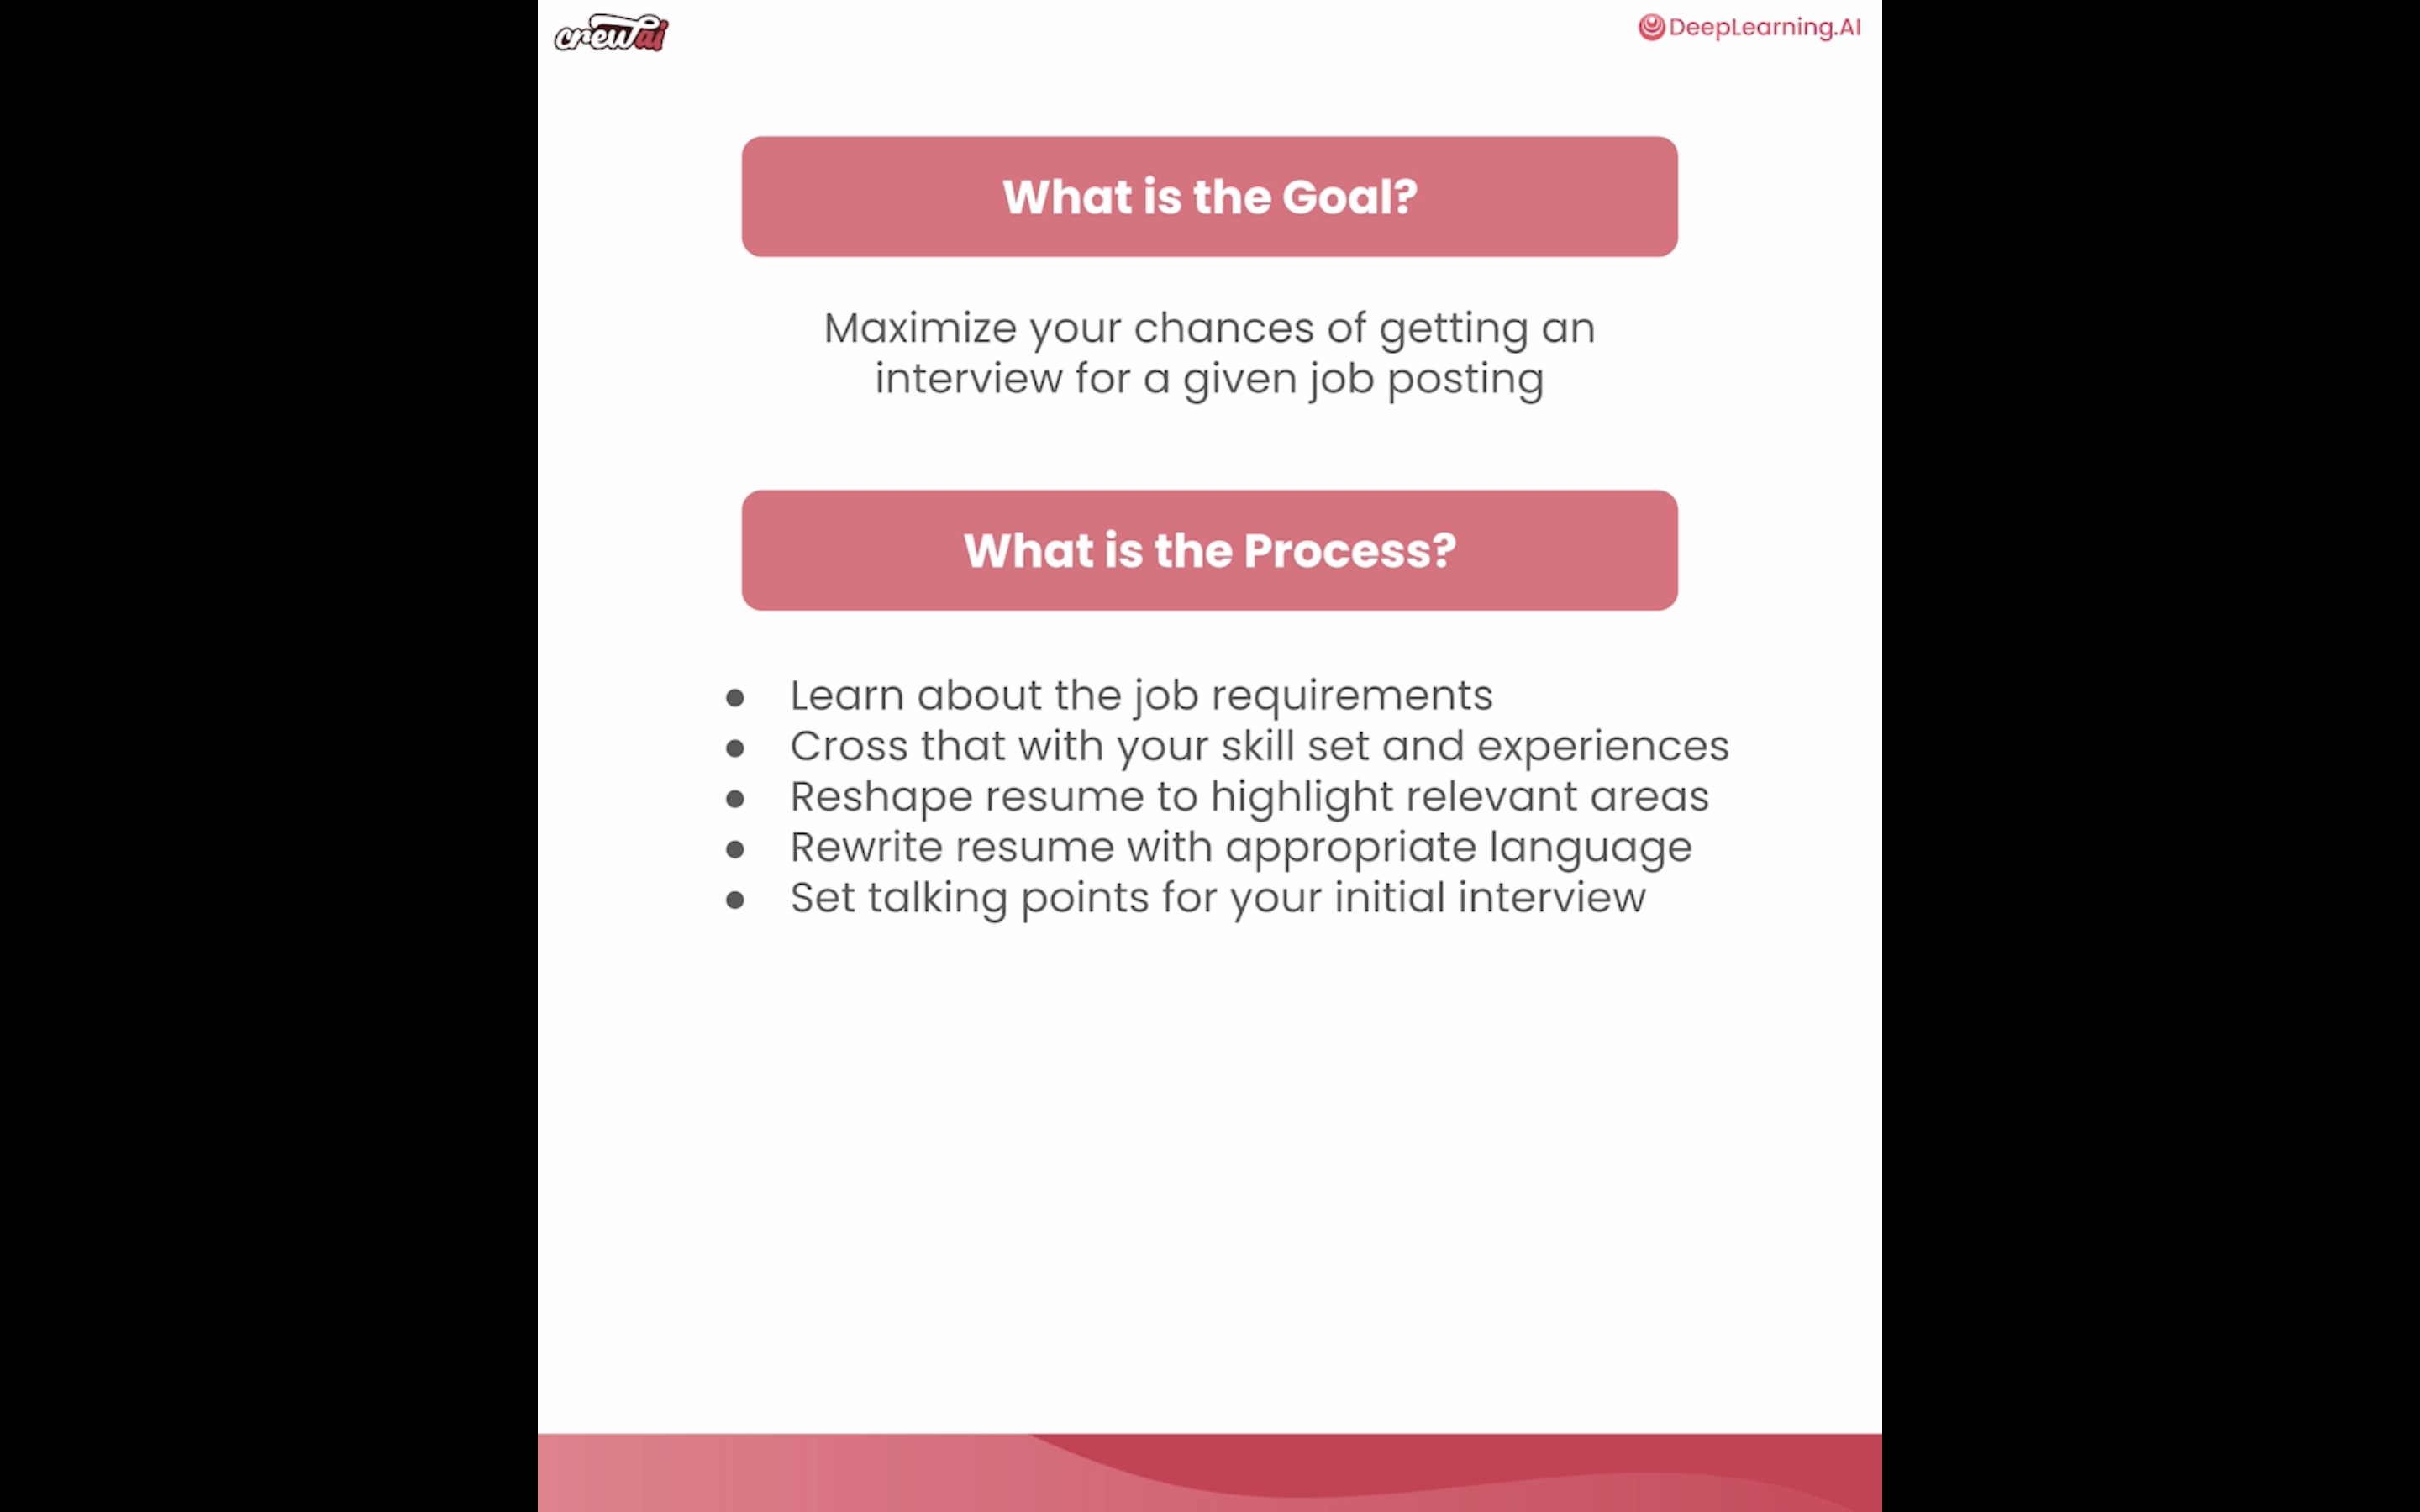

The libraries are already installed in the classroom. If you're running this notebook on your own machine, you can install the following:
```Python
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29
```

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

- Import libraries, APIs and LLM

In [2]:
from crewai import Agent, Task, Crew

**Note**: 
- The video uses `gpt-4-turbo`, but due to certain constraints, and in order to offer this course for free to everyone, the code you'll run here will use `gpt-3.5-turbo`.
- You can use `gpt-4-turbo` when you run the notebook _locally_ (using `gpt-4-turbo` will not work on the platform)
- Thank you for your understanding!

In [3]:
import os
from utils import get_openai_api_key, get_serper_api_key

openai_api_key = get_openai_api_key()
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'
os.environ["SERPER_API_KEY"] = get_serper_api_key()

## crewAI Tools

In [4]:
from crewai_tools import (
  FileReadTool,
  ScrapeWebsiteTool,
  MDXSearchTool,
  SerperDevTool
)

search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()
read_resume = FileReadTool(file_path='./fake_resume.md')
semantic_search_resume = MDXSearchTool(mdx='./fake_resume.md')

Inserting batches in chromadb: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


- Uncomment and run the cell below if you wish to view `fake_resume.md` in the notebook.

In [ ]:
# from IPython.display import Markdown, display
# display(Markdown("./fake_resume.md"))

## Creating Agents

In [6]:
# Agent 1: Researcher
researcher = Agent(
    role="Tech Job Researcher",
    goal="Make sure to do amazing analysis on "
         "job posting to help job applicants",
    tools = [scrape_tool, search_tool],
    verbose=True,
    backstory=(
        "As a Job Researcher, your prowess in "
        "navigating and extracting critical "
        "information from job postings is unmatched."
        "Your skills help pinpoint the necessary "
        "qualifications and skills sought "
        "by employers, forming the foundation for "
        "effective application tailoring."
    )
)

In [8]:
# Agent 2: Profiler
profiler = Agent(
    role="Personal Profiler for Engineers",
    goal="Do increditble research on job applicants "
         "to help them stand out in the job market",
    tools = [scrape_tool, search_tool,
             read_resume, semantic_search_resume],
    verbose=True,
    backstory=(
        "Equipped with analytical prowess, you dissect "
        "and synthesize information "
        "from diverse sources to craft comprehensive "
        "personal and professional profiles, laying the "
        "groundwork for personalized resume enhancements."
    )
)

In [9]:
# Agent 3: Resume Strategist
resume_strategist = Agent(
    role="Resume Strategist for Engineers",
    goal="Find all the best ways to make a "
         "resume stand out in the job market.",
    tools = [scrape_tool, search_tool,
             read_resume, semantic_search_resume],
    verbose=True,
    backstory=(
        "With a strategic mind and an eye for detail, you "
        "excel at refining resumes to highlight the most "
        "relevant skills and experiences, ensuring they "
        "resonate perfectly with the job's requirements."
    )
)

In [10]:
# Agent 4: Interview Preparer
interview_preparer = Agent(
    role="Engineering Interview Preparer",
    goal="Create interview questions and talking points "
         "based on the resume and job requirements",
    tools = [scrape_tool, search_tool,
             read_resume, semantic_search_resume],
    verbose=True,
    backstory=(
        "Your role is crucial in anticipating the dynamics of "
        "interviews. With your ability to formulate key questions "
        "and talking points, you prepare candidates for success, "
        "ensuring they can confidently address all aspects of the "
        "job they are applying for."
    )
)

## Creating Tasks

In [11]:
# Task for Researcher Agent: Extract Job Requirements
research_task = Task(
    description=(
        "Analyze the job posting URL provided ({job_posting_url}) "
        "to extract key skills, experiences, and qualifications "
        "required. Use the tools to gather content and identify "
        "and categorize the requirements."
    ),
    expected_output=(
        "A structured list of job requirements, including necessary "
        "skills, qualifications, and experiences."
    ),
    agent=researcher,
    async_execution=True
)

In [12]:
# Task for Profiler Agent: Compile Comprehensive Profile
profile_task = Task(
    description=(
        "Compile a detailed personal and professional profile "
        "using the GitHub ({github_url}) URLs, and personal write-up "
        "({personal_writeup}). Utilize tools to extract and "
        "synthesize information from these sources."
    ),
    expected_output=(
        "A comprehensive profile document that includes skills, "
        "project experiences, contributions, interests, and "
        "communication style."
    ),
    agent=profiler,
    async_execution=True
)

- You can pass a list of tasks as `context` to a task.
- The task then takes into account the output of those tasks in its execution.
- The task will not run until it has the output(s) from those tasks.

In [13]:
# Task for Resume Strategist Agent: Align Resume with Job Requirements
resume_strategy_task = Task(
    description=(
        "Using the profile and job requirements obtained from "
        "previous tasks, tailor the resume to highlight the most "
        "relevant areas. Employ tools to adjust and enhance the "
        "resume content. Make sure this is the best resume even but "
        "don't make up any information. Update every section, "
        "inlcuding the initial summary, work experience, skills, "
        "and education. All to better reflrect the candidates "
        "abilities and how it matches the job posting."
    ),
    expected_output=(
        "An updated resume that effectively highlights the candidate's "
        "qualifications and experiences relevant to the job."
    ),
    output_file="tailored_resume.md",
    context=[research_task, profile_task],
    agent=resume_strategist
)

In [14]:
# Task for Interview Preparer Agent: Develop Interview Materials
interview_preparation_task = Task(
    description=(
        "Create a set of potential interview questions and talking "
        "points based on the tailored resume and job requirements. "
        "Utilize tools to generate relevant questions and discussion "
        "points. Make sure to use these question and talking points to "
        "help the candiadte highlight the main points of the resume "
        "and how it matches the job posting."
    ),
    expected_output=(
        "A document containing key questions and talking points "
        "that the candidate should prepare for the initial interview."
    ),
    output_file="interview_materials.md",
    context=[research_task, profile_task, resume_strategy_task],
    agent=interview_preparer
)


## Creating the Crew

In [15]:
job_application_crew = Crew(
    agents=[researcher,
            profiler,
            resume_strategist,
            interview_preparer],

    tasks=[research_task,
           profile_task,
           resume_strategy_task,
           interview_preparation_task],

    verbose=True
)

## Running the Crew

- Set the inputs for the execution of the crew.

In [16]:
job_application_inputs = {
    'job_posting_url': 'https://jobs.lever.co/AIFund/6c82e23e-d954-4dd8-a734-c0c2c5ee00f1?lever-origin=applied&lever-source%5B%5D=AI+Fund',
    'github_url': 'https://github.com/joaomdmoura',
    'personal_writeup': """Noah is an accomplished Software
    Engineering Leader with 18 years of experience, specializing in
    managing remote and in-office teams, and expert in multiple
    programming languages and frameworks. He holds an MBA and a strong
    background in AI and data science. Noah has successfully led
    major tech initiatives and startups, proving his ability to drive
    innovation and growth in the tech industry. Ideal for leadership
    roles that require a strategic and innovative approach."""
}

**Note**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

In [17]:
### this execution will take a few minutes to run
result = job_application_crew.kickoff(inputs=job_application_inputs)

 [DEBUG]: == Working Agent: Tech Job Researcher
 [INFO]: == Starting Task: Analyze the job posting URL provided (https://jobs.lever.co/AIFund/6c82e23e-d954-4dd8-a734-c0c2c5ee00f1?lever-origin=applied&lever-source%5B%5D=AI+Fund) to extract key skills, experiences, and qualifications required. Use the tools to gather content and identify and categorize the requirements.
 [DEBUG]: == [Tech Job Researcher] Task output: 


 [DEBUG]: == Working Agent: Personal Profiler for Engineers
 [INFO]: == Starting Task: Compile a detailed personal and professional profile using the GitHub (https://github.com/joaomdmoura) URLs, and personal write-up (Noah is an accomplished Software
    Engineering Leader with 18 years of experience, specializing in
    managing remote and in-office teams, and expert in multiple
    programming languages and frameworks. He holds an MBA and a strong
    background in AI and data science. Noah has successfully led
    major tech initiatives and startups, proving his abili

Action Input: {"website_url": "https://crewai.com"} 

CrewAI
CrewAI partners with IBM to elevate AI-driven solutions for smarter business growth!  Learn MoreHomeEnterpriseOpen SourceEcosystemUse CasesTemplatesBlogLoginStart Enterprise TrialcrewAI © Copyright 2024Log inStart Enterprise TrialThe LeadingMulti-Agent PlatformTheLeadingMulti-AgentPlatformStreamline workflows across industries with powerful AI agents. Build and deploy automated workflows using any LLM and cloud platform.Start Free TrialI Want A Demo100,000,000+75,000,00050,000,00025,000,00010,000,0007,500,0005,000,0002,500,0001,000,000750,000500,000250,000100,00075,00050,00025,00010,0005,0002,5001,00050025010050100Multi-Agent Crews run using CrewAI Trusted By Industry LeadersThe Complete Platform for Multi-Agent Automation1. Build QuicklyStart by using CrewAI’s framework or UI Studio to build your multi-agent automations—whether coding from scratch or leveraging our no-code tools and templates.2. Deploy ConfidentlyMove the cr

Final Answer: 
- Proven experience as a Full Stack Developer or similar role
- Experience developing desktop and mobile applications
- Familiarity with common stacks
- Knowledge of multiple front-end languages and libraries (e.g. HTML/ CSS, JavaScript, XML, jQuery)
- Knowledge of multiple object-oriented languages (e.g. Java, Python) and multiple frameworks (e.g. Angular, React, Node.js)
- Familiarity with databases (e.g. MySQL, MongoDB), web servers (e.g. Apache) and UI/UX design
- Excellent communication skills and the ability to have in-depth technical discussions with both the engineering team and business people
- Excellent English language skills
- Self-starter and comfort working in an early-stage environment
- Strong project management and organizational skills
- BSc in Computer Science, Mathematics or similar field; Master’s or PhD degree is a plus
- Understanding of AI/ML models
- Understanding of big data tools, including Hadoop, Spark, Kafka, etc.
- Proficiency in HTML, CSS

Final Answer:
# Noah Williams
- Email: noah.williams@example.dev
- Phone: +44 11 111 11111

## Profile
Noah Williams is a distinguished Software Engineering Leader with an 18-year tenure in the technology industry, where he has excelled in leading both remote and in-office engineering teams. His expertise spans across software development, process innovation, and enhancing team collaboration. He is highly proficient in programming languages such as Ruby, Python, JavaScript, TypeScript, and Elixir, alongside deep expertise in various front end frameworks. Noah's significant experience in data science and machine learning has enabled him to spearhead successful deployments of scalable AI solutions and innovative data model development.

## Work History

### DataKernel: Director of Software Engineering (remote) — 2022 - Present
- Noah has transformed the engineering division into a key revenue pillar for DataKernel, rapidly expanding the customer base from inception to a robust community.

I need to create a set of potential interview questions and talking points based on Noah's resume and the job requirements provided.

Action: Read a file's content
Action Input: {} 


# Noah Williams
- Email: noah.williams@example.dev
- Phone: +44 11 111 11111

## Profile
Noah Williams is a distinguished Software Engineering Leader with an 18-year tenure in the technology industry, where he has excelled in leading both remote and in-office engineering teams. His expertise spans across software development, process innovation, and enhancing team collaboration. He is highly proficient in programming languages such as Ruby, Python, JavaScript, TypeScript, and Elixir, alongside deep expertise in various front end frameworks. Noah's significant experience in data science and machine learning has enabled him to spearhead successful deployments of scalable AI solutions and innovative data model development.

## Work History

### DataKernel: Director of Software Engineering (remote) — 2022 - P

- Dislplay the generated `tailored_resume.md` file.

In [18]:
from IPython.display import Markdown, display
display(Markdown("./tailored_resume.md"))

# Noah Williams
- Email: noah.williams@example.dev
- Phone: +44 11 111 11111

## Profile
Noah Williams is a distinguished Software Engineering Leader with an 18-year tenure in the technology industry, where he has excelled in leading both remote and in-office engineering teams. His expertise spans across software development, process innovation, and enhancing team collaboration. He is highly proficient in programming languages such as Ruby, Python, JavaScript, TypeScript, and Elixir, alongside deep expertise in various front end frameworks. Noah's significant experience in data science and machine learning has enabled him to spearhead successful deployments of scalable AI solutions and innovative data model development.

## Work History

### DataKernel: Director of Software Engineering (remote) — 2022 - Present
- Noah has transformed the engineering division into a key revenue pillar for DataKernel, rapidly expanding the customer base from inception to a robust community.
- He spearheaded the integration of cutting-edge AI technologies and the use of scalable vector databases, which significantly enhanced the product's capabilities and market positioning.
- Under his leadership, the team has seen substantial growth in skill development, with a focus on achieving strategic project goals that have significantly influenced the company's direction.
- Noah also played a critical role in defining the company’s long-term strategic initiatives, particularly in adopting AI technologies that have set new benchmarks within the industry.

### DataKernel: Senior Software Engineering Manager (remote) — 2019 - 2022
- Directed the engineering strategy and operations in close collaboration with C-level executives, playing a pivotal role in shaping the company's technological trajectory.
- Managed diverse teams across multiple time zones in North America and Europe, creating an environment of transparency and mutual respect which enhanced team performance and morale.
- His initiatives in recruiting, mentoring, and retaining top talent have been crucial in fostering a culture of continuous improvement and high performance.

### InnovPet: Founder & CEO (remote) — 2019 - 2022
- Noah founded InnovPet, a startup focused on innovative IoT solutions for pet care, including a revolutionary GPS tracking collar that significantly enhanced pet safety and owner peace of mind.
- He was responsible for overseeing product development from concept through execution, working closely with engineering teams and marketing partners to ensure a successful market entry.
- Successfully set up an advisory board, established production facilities overseas, and navigated the company through a successful initial funding phase, showcasing his leadership and entrepreneurial acumen.
- Built the initial version of the product leveraging MongoDB

### EliteDevs: Engineering Manager (remote) — 2018 - 2019
- Noah was instrumental in formulating and executing strategic plans that enhanced inter-departmental coordination and trust, leading to better project outcomes.
- He managed multiple engineering teams, fostering a culture that balances productivity with innovation, and implemented goal-setting frameworks that aligned with the company's long-term goals.
- Was a very hands-on manager using Ruby on Rails and React to build out a new product.

### PrintPack: Engineering Manager (remote) — 2016 - 2018
- Led the formation and development of a high-performance engineering team that was pivotal in increasing company revenue by 500% within two years.
- His leadership in integrating data analytics into business decision-making processes led to the development of a predictive modeling tool that revolutionized customer behavior analysis.

### DriveAI: Senior Software Engineer (remote) — 2015 - 2016
- Developed and optimized a central API that significantly improved the functionality used by a large engineering team and thousands of users, enhancing overall system performance and user satisfaction.
- Implemented several critical enhancements, including advanced caching strategies that drastically reduced response times and system loads.

### BetCraft: CTO — 2013 - 2015
- Led the technology strategy post-Series A funding, directly reporting to the board and guiding the company through a phase of significant technological advancement and network expansion.
- His strategic initiatives and partnerships significantly improved platform performance and expanded the company's market reach.
- Helped build his initial product using both React and Angular and got pretty good at it.

## Education

### MBA in Information Technology
London Business School - MBA

### Advanced Leadership Techniques
University of London - Certification

### Data Science Specialization
Coursera (Johns Hopkins University) - Certification

### B.Sc. in Computer Science
University of Edinburgh - Bachelor’s degree

Noah Williams is an ideal candidate for senior executive roles, particularly in companies seeking leadership with a robust blend of technical and strategic expertise.

- Dislplay the generated `interview_materials.md` file.

In [19]:
display(Markdown("./interview_materials.md"))

Based on Noah Williams' resume and the job requirements, here are some potential interview questions and talking points for the initial interview:

1. Can you walk us through a project where you successfully implemented AI-driven solutions for business growth, such as the use of scalable vector databases at DataKernel?

2. How do you approach managing remote and in-office engineering teams to ensure transparency, mutual respect, and high performance, as seen in your role at DataKernel and EliteDevs?

3. In what ways have you leveraged your expertise in Ruby, Python, JavaScript, TypeScript, and Elixir to lead software development projects and enhance team collaboration?

4. Could you share an example of a strategic initiative you spearheaded at InnovPet that resulted in successful market entry and product development, especially in relation to building the initial version of the product using MongoDB?

5. How have you integrated data analytics into business decision-making processes to develop predictive modeling tools, as seen during your tenure at PrintPack?

6. Describe your experience in managing diverse teams across different time zones, recruiting, mentoring, and retaining top talent, and fostering a culture of continuous improvement and high performance at DataKernel and EliteDevs.

7. Can you elaborate on your role as a CTO at BetCraft, where you led the technology strategy post-Series A funding, improved platform performance, and expanded market reach through strategic initiatives and partnerships using React and Angular?

8. How have your educational background in MBA in Information Technology, Advanced Leadership Techniques, Data Science Specialization, and B.Sc. in Computer Science contributed to your leadership style and strategic approach in the tech industry?

9. Given your interest in AI, machine learning, and data science, how do you stay updated with emerging technologies and innovative solutions to optimize performance metrics and drive innovation in your projects?

10. In what ways do you effectively communicate complex technical concepts to non-technical audiences and collaborate with industry leaders to implement AI automation and growth strategies, as showcased in your work history?

These questions and talking points aim to highlight Noah's extensive experience, skills, and achievements in software engineering leadership, AI, data science, and team management, aligning with the job requirements outlined for the position.